# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,os,shutil
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown
import pylhe, gzip, tempfile

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
# Dictionaries for naming variables:
labelsDict = {'Top-FormFactorsOneLoop-UFO' : '1-loop', 'Top-EFTphysical_simple-UFO' : 'EFT', 
              'SMS-stop-UFO' : 'SM', 'SMS-stop-NLO_SMQCD-UFO' : 'SM',
              'g g > t t~' : r'$g g \to \bar{t} t$', 'g g > t~ t' : r'$g g \to \bar{t} t$',
              'q q > t t~' : r'$q q \to \bar{t} t$', 'q q > t~ t' : r'$q q \to \bar{t} t$'
             }


In [3]:
def getInfo(f):
    
    banner = list(glob.glob(os.path.join(os.path.dirname(f),'*banner*')))[0]
    with open(banner,'r') as bannerF:
        bannerData = bannerF.read()
    
    # Get process data:
    processData = bannerData.split('<MGProcCard>')[1].split('</MGProcCard>')[0]
#     print(processData)
    # Get model
    model = processData.split('Begin MODEL')[1].split('End   MODEL')[0]
    model = model.split('\n')[1].strip()
    model = labelsDict[model]
    # Get process
    proc = processData.split('Begin PROCESS')[1].split('End PROCESS')[0]
    proc = proc.split('\n')[1].split('#')[0].strip()
    proc = labelsDict[proc]
    
    # Get parameters data:
    parsData = bannerData.split('<slha>')[1].split('</slha>')[0]
    parsSLHA = pyslha.readSLHA(parsData)
    
    mST = parsSLHA.blocks['MASS'][5000002]
    mChi = parsSLHA.blocks['MASS'][5000012]
    mT  = parsSLHA.blocks['MASS'][6]
    yDM = list(parsSLHA.blocks['FRBLOCK'].values())[-1]

    
    # Get event data:
    eventData = bannerData.split('<MGGenerationInfo>')[1].split('</MGGenerationInfo>')[0]
    nEvents = eval(eventData.split('\n')[1].split(':')[1].strip())
    xsec = eval(eventData.split('\n')[2].split(':')[1].strip())

    fileInfo = {'model' : model, 'process' : proc, '(mST,mChi,mT,yDM)' : (mST,mChi,mT,yDM),
               'xsec (pb)' : xsec, 'nevents' : nEvents}
    return fileInfo


In [4]:
files = list(glob.glob('../validation/top_eft/gg2tt_onlyInter/Events/*/unweighted_events.lhe.gz'))
files += list(glob.glob('../validation/top_eft/gg2tt_onlyInterBias/Events/*/unweighted_events.lhe.gz'))
files += list(glob.glob('../validation/sms_nlo/gg2tt_born/Events/*/unweighted_events.lhe.gz'))

In [5]:
# Get info
fileData = {f : getInfo(f) for f in files}
for f in fileData:
    if 'Bias' in f:
        fileData[f]['model'] = 'EFT-Bias'
        if 'run_02' in f:
            fileData[f]['model'] = 'EFT-Bias3'
        if 'run_03' in f:
            fileData[f]['model'] = 'EFT-Bias4'

            
allModels = sorted(list(set([info['model'] for info in fileData.values()])))
allPars = sorted(list(set([info['(mST,mChi,mT,yDM)'] for info in fileData.values()])))
allProcesses = sorted(list(set([info['process'] for info in fileData.values()])))
print(allModels)
print(allPars)
print(allProcesses)

['EFT', 'EFT-Bias', 'EFT-Bias3', 'EFT-Bias4', 'SM']
[(400.0, 100.0, 172.0, 1.0), (600.0, 550.0, 172.0, 1.0), (5000.0, 4900.0, 172.0, 1.0)]
['$g g \\to \\bar{t} t$']


In [6]:
# Select files:
models = ['SM','EFT-Bias','EFT-Bias4']
pars = [(600.,550.,172.,1.0)]
procs = allProcesses[:]

bsmFiles = []
smFiles = []
for f,fInfo in fileData.items():
    if fInfo['model'] not in models:
        continue
    if fInfo['process'] not in procs:
        continue
        
    if fInfo['model'] == 'SM':
        smFiles.append(f)
    else:
        if fInfo['(mST,mChi,mT,yDM)'] not in pars:
            continue
        bsmFiles.append(f)
    
# print(bsmFiles)
# print(smFiles)
# Sort files so largest cross-sections come first
bsmFiles = sorted(bsmFiles, key = lambda f: fileData[f]['xsec (pb)'], reverse=True)
smFiles = sorted(smFiles, key = lambda f: fileData[f]['xsec (pb)'], reverse=True)
selectedFiles = smFiles+bsmFiles

In [7]:
# It is necessary to remove the < signs from the LHE files (in the generate line) before parsing with pylhe
events = {}
for fpath in selectedFiles:
    fixedFile = tempfile.mkstemp(suffix='.lhe')
    os.close(fixedFile[0])
    fixedFile = fixedFile[1]
    with  gzip.open(fpath,'rt') as f:
        data = f.readlines()
        with open(fixedFile,'w') as newF:
            for l in data:
                if 'generate' in l:
                    continue
                newF.write(l)
    events[fpath] = pylhe.read_lhe_with_attributes(fixedFile)

In [8]:
mtt = {}
mcTotal = {f : 0 for f in selectedFiles}
weightsDict = {f : [] for f in selectedFiles}
for f,r in events.items():
    pT1 = []
    pT2 = []
    mTT = []
    for iev,ev in enumerate(r):
        weightsDict[f].append(ev.eventinfo.weight)
        mcTotal[f] += 1
        for ptc in ev.particles:
            if abs(ptc.id) != 6: continue
            if ptc.id == 6:
                pA = np.array([ptc.px,ptc.py,ptc.pz,ptc.e])
            else:
                pB = np.array([ptc.px,ptc.py,ptc.pz,ptc.e])

        pT1.append(max(np.linalg.norm(pA[0:3]),np.linalg.norm(pB[0:3])))
        pT2.append(min(np.linalg.norm(pA[0:3]),np.linalg.norm(pB[0:3])))
        mTT.append(np.sqrt((pA[-1]+pB[-1])**2-np.linalg.norm(pA[0:3]+pB[0:3])**2))
    mtt[f] = {'pT1' : pT1, 'pT2' : pT2, 'mTT' : mTT}

In [9]:
for f,w in weightsDict.items():
    weightsDict[f] = np.array(w)/mcTotal[f]
    print('\n %s : %s' %(fileData[f]['model'],fileData[f]['process']))
    print('total xsec    = ',sum(weightsDict[f]))
    print('  (from file) = ',fileData[f]['xsec (pb)'])


 SM : $g g \to \bar{t} t$
total xsec    =  454.6241100000459
  (from file) =  454.62411000000003

 EFT-Bias4 : $g g \to \bar{t} t$
total xsec    =  -0.05740427358739594
  (from file) =  -0.0041740674

 EFT-Bias : $g g \to \bar{t} t$
total xsec    =  -0.056936838205432966
  (from file) =  -0.007434719


In [10]:
# Define colors
colors = {f : sns.color_palette('deep')[i] for i,f in enumerate(mtt.keys())}

In [11]:
# Define scale factor (new yDM value)
kscales = {f : 1.0 for f in smFiles}
kscales.update({f : 1000 for f in bsmFiles})

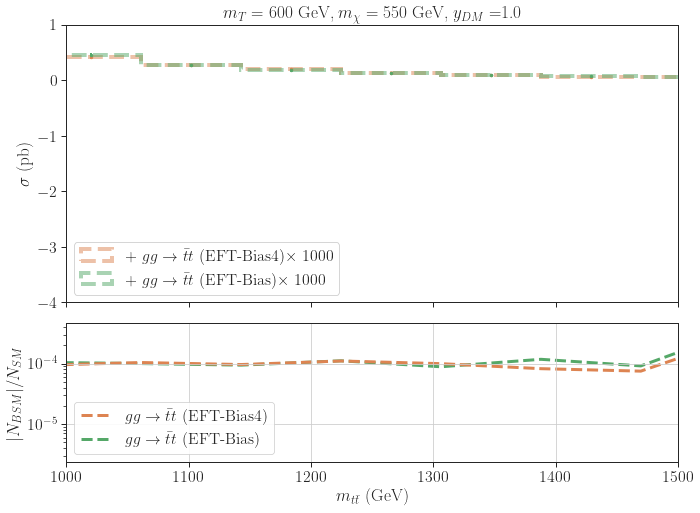

In [18]:
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
bins = np.linspace(0.,4000.,50)

labels = []
pmodels = []
hists = []
histsErr = []
c = []
ks = []
for f in mtt:
    process = fileData[f]['process']
    model = fileData[f]['model']
    mST,mChi,mT,yDM = fileData[f]['(mST,mChi,mT,yDM)']
    
    kscale = kscales[f]
#     if f in bsmFiles:
#         continue
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    if labels:
        label = ' + ' + label
    if kscale != 1.0:
        label += r'$ \times $ %1.0f' %kscale
    labels.append(label)
    c.append(colors[f])
    ks.append(kscale)
    h,_ = np.histogram(mtt[f]['mTT'],bins=bins,weights=kscale*weightsDict[f])
    hErr,_ = np.histogram(mtt[f]['mTT'],bins=bins,weights=(kscale*weightsDict[f])**2)
    hErr = np.sqrt(hErr)
    hists.append(h)
    histsErr.append(hErr)
    

histsSM = [h for i,h in enumerate(hists) if 'SM' in labels[i]]
histsErrSM = [h for i,h in enumerate(histsErr) if 'SM' in labels[i]]
labelsSM = [l for i,l in enumerate(labels) if 'SM' in labels[i]]    
cSM =  [cc for i,cc in enumerate(c) if 'SM' in labels[i]]    
# axarr[0].hist([bins[:-1]]*len(histsSM),label=labelsSM,bins=bins,
#                           weights=histsSM,alpha=0.3,
#                           density=False,linewidth=1,color=cSM,stacked=True)

hSM = sum([hh for hh in histsSM[:]])
hErrSM = np.sqrt(sum([hh**2 for hh in histsErrSM[:]]))
hTot = np.copy(hSM)
hTotErr = np.copy(hErrSM)
for i,h in enumerate(hists):
    if 'SM' in labels[i]:
        continue    
    hErr = histsErr[i]
    hTot = np.abs(h)
    hTotErr= hErr
    axarr[0].hist(bins[:-1],weights=hTot,label=labels[i],bins=bins,
                  color=c[i],alpha=0.5,histtype='step',
                  linewidth=4,fill=False,zorder=i,linestyle='--')

    
    bincenters = 0.5*(bins[1:]+bins[:-1])
    axarr[0].errorbar(bincenters,hTot,yerr=hTotErr, marker = '.', elinewidth=2.0,
                 drawstyle = 'steps-mid',linewidth=0.0,color=c[i],alpha=1.0)


    ratio = np.divide(np.abs(h)/ks[i], hSM, out=np.zeros_like(np.abs(h)), where=hSM != 0)
    axarr[1].plot(bins[:-1],ratio,linewidth=3.0,linestyle='--', 
                          label=pmodels[i],c=c[i],zorder=-i)


    
# axarr[0].set_yscale('log')
axarr[0].set_ylim(1-5,1)
axarr[0].set_xlim(1000,1500)
axarr[1].set_xlabel(r'$m_{t\bar{t}}$ (GeV)')
axarr[0].set_ylabel(r'$\sigma$ (pb)')
axarr[1].set_ylabel(r'$|N_{BSM}|/N_{SM}$')
# axarr[1].set_ylim(1e-3,1)
axarr[1].set_yscale('log')
axarr[1].grid()

axarr[0].legend(framealpha=1.0)
axarr[1].legend(framealpha=0.9)
axarr[0].set_title(r'$m_{T} = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mST,mChi,yDM))
plt.show()

In [13]:
for f,wList in weightsDict.items():
    print(fileData[f])
    print(wList.max(),wList.min())

{'model': 'SM', 'process': '$g g \\to \\bar{t} t$', '(mST,mChi,mT,yDM)': (400.0, 100.0, 172.0, 1.0), 'xsec (pb)': 454.62411000000003, 'nevents': 10000}
0.045462410999999994 0.045462410999999994
{'model': 'EFT-Bias4', 'process': '$g g \\to \\bar{t} t$', '(mST,mChi,mT,yDM)': (600.0, 550.0, 172.0, 1.0), 'xsec (pb)': -0.0041740674, 'nevents': 10000}
-7.7094771e-08 -1.4105862999999999e-05
{'model': 'EFT-Bias', 'process': '$g g \\to \\bar{t} t$', '(mST,mChi,mT,yDM)': (600.0, 550.0, 172.0, 1.0), 'xsec (pb)': -0.007434719, 'nevents': 10000}
-9.2337843e-08 -1.4115056000000001e-05
